In [83]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('ireland_data_final_clean.csv')

# Define target and features
target_col = 'Ireland_Homeless_PerCapita'
feature_cols = [col for col in df.columns if col != target_col and 'Year' not in col]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(df[feature_cols]), columns=feature_cols)
y = df[target_col].values

# Normalize data (for Random Forest only)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=feature_cols)

In [85]:
# Initialize LOOCV
loo = LeaveOneOut()

# Set up containers for predictions
ridge_preds = np.zeros_like(y)
lasso_preds = np.zeros_like(y)
rf_preds = np.zeros_like(y)

In [87]:
# Best model params (pre-tuned or use same GridSearch logic inside loop if needed)
ridge_best = Ridge(alpha=0.001)

# Initialize Random Forest model for hyperparameter tuning with GridSearchCV
rf_best = RandomForestRegressor(random_state=42)

In [89]:
# GridSearchCV for Random Forest to find the best hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [5, 10, 15, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Split criteria
    'min_samples_leaf': [1, 2, 4],  # Leaf criteria
    'max_features': ['auto', 'sqrt', 'log2'],  # Features to consider for split
}
grid_search_rf = GridSearchCV(estimator=rf_best, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_scaled, y)

# Best Random Forest model from GridSearchCV
rf_best = grid_search_rf.best_estimator_

In [91]:
# Hyperparameter tuning for Lasso using GridSearchCV
lasso_param_grid = {'alpha': np.logspace(-4, 1, 6)}  # Range of alpha values
lasso_grid_search = GridSearchCV(Lasso(max_iter=100000), lasso_param_grid, cv=5)
lasso_grid_search.fit(X_scaled, y)

# Update Lasso with the best alpha from GridSearchCV
lasso_best = lasso_grid_search.best_estimator_

In [93]:
# Manual LOOCV loop
for train_index, test_index in loo.split(X_scaled):
    X_train_scaled, X_test_scaled = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    X_train_raw, X_test_raw = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_best.fit(X_train_scaled, y_train)
    lasso_best.fit(X_train_scaled, y_train)
    rf_best.fit(X_train_raw, y_train)

    ridge_preds[test_index] = ridge_best.predict(X_test_scaled)
    lasso_preds[test_index] = lasso_best.predict(X_test_scaled)
    rf_preds[test_index] = rf_best.predict(X_test_raw)

In [95]:
# Evaluate true RMSE & R² based on out-of-fold predictions
ridge_rmse = np.sqrt(mean_squared_error(y, ridge_preds))
lasso_rmse = np.sqrt(mean_squared_error(y, lasso_preds))
rf_rmse = np.sqrt(mean_squared_error(y, rf_preds))

ridge_r2 = r2_score(y, ridge_preds)
lasso_r2 = r2_score(y, lasso_preds)
rf_r2 = r2_score(y, rf_preds)

In [97]:
# Calculate MAE for each model
ridge_mae = mean_absolute_error(y, ridge_preds)
lasso_mae = mean_absolute_error(y, lasso_preds)
rf_mae = mean_absolute_error(y, rf_preds)

In [99]:
# Print Final Results (Leak-Free)
print("FINAL MODEL RESULTS (LOOCV Evaluation Only)")
print(f"RIDGE → RMSE: {ridge_rmse:.8f} | R²: {ridge_r2:.4f} | MAE: {ridge_mae:.8f}")
print(f"LASSO → RMSE: {lasso_rmse:.8f} | R²: {lasso_r2:.4f} | MAE: {lasso_mae:.8f}")
print(f"RF    → RMSE: {rf_rmse:.8f} | R²: {rf_r2:.4f} | MAE: {rf_mae:.8f}")

FINAL MODEL RESULTS (LOOCV Evaluation Only)
RIDGE → RMSE: 0.00021726 | R²: 0.8951 | MAE: 0.00017245
LASSO → RMSE: 0.00022915 | R²: 0.8833 | MAE: 0.00018599
RF    → RMSE: 0.00019755 | R²: 0.9132 | MAE: 0.00016513


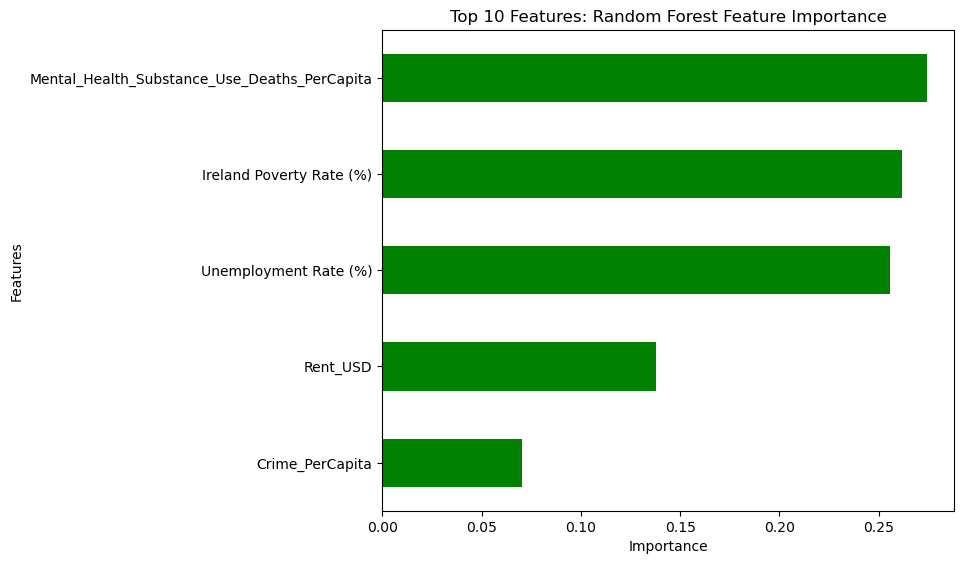

In [101]:
# Plotting the top 10 features based on Random Forest feature importance (sorted from high to low)
# Select the top 10 most important features
top_10_features = feature_importance_rf.head(10)

# Plot the top 10 features (sorted from high to low)
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh', color='green')
plt.title("Top 10 Features: Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Inverts the y-axis to display the most important feature at the top
plt.tight_layout(pad=2.0)
plt.savefig('top_10_features_rf_importance.png', bbox_inches='tight')